In [1]:
import pandas as pd
import re

from transformers import pipeline

In [4]:
tesla_tweets = pd.read_csv('Datasets/tesla_and_others.csv')
print(tesla_tweets.head())

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [5]:
tesla_tweets = tesla_tweets[tesla_tweets['Stock Name'] == 'TSLA']
print(tesla_tweets.head())

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [6]:
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].apply(lambda x: re.sub(r'http\S+|www.\S+|@\w+|#\w+', '', x))
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].str.lower()
tesla_tweets['Date'] = pd.to_datetime(tesla_tweets['Date']).dt.date
print(tesla_tweets['Date'].head())

0    2022-09-29
1    2022-09-29
2    2022-09-29
3    2022-09-29
4    2022-09-29
Name: Date, dtype: object


In [7]:
tesla_tweets = tesla_tweets.dropna(subset=['Tweet', 'Date']).drop_duplicates()
tesla_tweets = tesla_tweets.drop_duplicates(subset='Tweet')
tesla_tweets = tesla_tweets.drop(columns=['Stock Name', 'Company Name'], errors='ignore')
print(tesla_tweets.head())

         Date                                              Tweet
0  2022-09-29  mainstream media has done an amazing job at br...
1  2022-09-29  tesla delivery estimates are at around 364k fr...
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...
3  2022-09-29     hahaha why are you still trying to stop tes...
4  2022-09-29    stop trying to kill kids, you sad deranged o...


In [8]:
num_rows = tesla_tweets.shape[0]
start_date = tesla_tweets['Date'].min()
end_date = tesla_tweets['Date'].max()

print(f'Number of rows in the cleaned data: {num_rows}')
print(f'Start date of tweets: {start_date}')
print(f'End date of tweets: {end_date}')

Number of rows in the cleaned data: 37106
Start date of tweets: 2021-09-30
End date of tweets: 2022-09-29


In [ ]:
# load FinBERT model for sentiment analysis
# sentiment_pipeline = pipeline('sentiment-analysis', model='yiyanghkust/finbert-tone', tokenizer='yiyanghkust/finbert-tone', device=0)
sentiment_pipeline = pipeline('sentiment-analysis', model='yiyanghkust/finbert-tone', tokenizer='yiyanghkust/finbert-tone')

# run sentiment classification on the 'Tweet' column in batches with truncation
sentiment_pipeline.tokenizer.model_max_length = 512
sentiment_pipeline.tokenizer.truncation = True
batch_size = 16
tweet_texts = tesla_tweets['Tweet'].tolist()

sentiment_results = []
for i in range(0, len(tweet_texts), batch_size):
    print(f'Start: i={i}')
    batch = tweet_texts[i:i + batch_size]
    sentiments = sentiment_pipeline(batch, truncation = True)
    sentiment_results.extend(sentiments)
    print(f'End: i={i}')

tesla_tweets['Sentiment'] = [result['label'] for result in sentiment_results]

In [28]:
print(tesla_tweets.head())
sentiment_counts = tesla_tweets['Sentiment'].value_counts()
print(sentiment_counts)

         Date                                              Tweet Sentiment
0  2022-09-29  mainstream media has done an amazing job at br...  Positive
1  2022-09-29  tesla delivery estimates are at around 364k fr...   Neutral
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...   Neutral
3  2022-09-29     hahaha why are you still trying to stop tes...   Neutral
4  2022-09-29    stop trying to kill kids, you sad deranged o...   Neutral
Sentiment
Neutral     27413
Positive     6899
Negative     2794
Name: count, dtype: int64


In [29]:
tesla_stock_data = pd.read_csv('Datasets/tesla_historical_stock_prices.csv')
print(tesla_stock_data.head())

        Date    Open    High     Low  Close   Adj Close       Volume
0  29-Sep-22  282.76  283.65  265.78  268.21      268.21  77,620,600
1  28-Sep-22  283.08  289.00  277.57  287.81      287.81  54,664,800
2  27-Sep-22  283.84  288.67  277.51  282.94      282.94  61,925,200
3  26-Sep-22  271.83  284.09  270.31  276.01      276.01  58,076,900
4  23-Sep-22  283.09  284.50  272.82  275.33      275.33  63,748,400


In [30]:
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'], format='%d-%b-%y')
tesla_stock_data.columns = tesla_stock_data.columns.str.strip()
tesla_stock_data = tesla_stock_data[['Date', 'Adj Close', 'Volume']].copy()
tesla_stock_data.rename(columns={'Adj Close': 'Price'}, inplace=True)
print(tesla_stock_data.head())

        Date   Price      Volume
0 2022-09-29  268.21  77,620,600
1 2022-09-28  287.81  54,664,800
2 2022-09-27  282.94  61,925,200
3 2022-09-26  276.01  58,076,900
4 2022-09-23  275.33  63,748,400


In [31]:
tesla_sentiment_data = tesla_tweets[['Date', 'Sentiment']]

# convert sentiment labels to numeric values
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
tesla_sentiment_data['sentiment_numeric'] = tesla_sentiment_data['Sentiment'].map(sentiment_mapping)
# make sure dates are in the right format
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'])
tesla_sentiment_data['Date'] = pd.to_datetime(tesla_sentiment_data['Date'])
# aggregate sentiment scores by date (taking the average sentiment for each day)
daily_sentiment = tesla_sentiment_data.groupby('Date')['sentiment_numeric'].mean().reset_index()

daily_sentiment.rename(columns={'sentiment_numeric': 'daily_sentiment'}, inplace=True)
# interpolate missing prices
tesla_stock_data = tesla_stock_data.set_index('Date').asfreq('D')
tesla_stock_data = tesla_stock_data.infer_objects(copy=False)
tesla_stock_data['Price'] = pd.to_numeric(tesla_stock_data['Price'], errors='coerce')
tesla_stock_data['Volume'] = pd.to_numeric(tesla_stock_data['Volume'], errors='coerce')
tesla_stock_data = tesla_stock_data.interpolate().reset_index()
# merge Tesla stock data with sentiment data on date
merged_data = pd.merge(tesla_stock_data, daily_sentiment, on='Date', how='inner')
print(merged_data.head())

        Date   Price  Volume  daily_sentiment
0 2021-09-30  258.49     NaN         0.133333
1 2021-10-01  258.41     NaN         0.148936
2 2021-10-02  259.11     NaN         0.295652
3 2021-10-03  259.81     NaN         0.278689
4 2021-10-04  260.51     NaN         0.169492


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [33]:
def prepare_sequences(data, lookback):
  """
  Prepare sequences for LSTM model.

  Args:
  data (pd.DataFrame): DataFrame with date, price, volume, and daily_sentiment
  lookback (int): No. of previous days to use for prediction

  Returns:
  X (np.array): Input features for LSTM
  y (np.array): Target stock prices
  """

  data = data.sort_values('Date')

  sentiment_data = data['daily_sentiment'].values
  price_data = data['Price'].values

  sentiment_scaler = MinMaxScaler(feature_range=(-1, 1))
  price_scaler = MinMaxScaler(feature_range=(0, 1))

  sentiment_scaled = sentiment_scaler.fit_transform(sentiment_data.reshape(-1, 1))
  price_scaled = price_scaler.fit_transform(price_data.reshape(-1, 1))

  X, y = [], []

  for i in range(len(data) - lookback):
    input_seq = np.column_stack([sentiment_scaled[i:i+lookback].flatten(), price_scaled[i:i+lookback].flatten()])
    X.append(input_seq)
    y.append(price_scaled[i+lookback])

  return np.array(X), np.array(y)

In [34]:
def create_lstm_model(input_shape):
  """
  Create LSTM model for stock price prediction.

  Args:
  input_shape (tuple): Shape of input data

  Returns:
  model (tf.keras.Model): LSTM model
  """

  model = Sequential([
      LSTM(units=128, activation='relu', return_sequences=True, input_shape=input_shape),
      Dropout(0.2),
      LSTM(units=128, activation='relu'),
      Dropout(0.2),
      Dense(units=25, activation='relu'),
      Dense(units=1)
  ])

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

In [35]:
def train_and_evaluate_model(data, lookback, test_size=0.2, epochs=50, batch_size=32):
  """
  Train and evaluate LSTM model for stock price prediction.

  Args:
  data (pd.DataFrame): DataFrame with date, price, volume, and daily_sentiment
  lookback (int): No. of previous days to use for prediction
  test_size (float): Proportion of data to use for testing
  epochs (int): No. of epochs to train the model
  batch_size (int): Batch size for training

  Returns:
  model (tf.keras.Model): Trained LSTM model
  history (tf.keras.callbacks.History): Training history
  """

  X, y = prepare_sequences(data, lookback)
  X = X.reshape(X.shape[0], X.shape[1], 2) # 2 features: sentiment and price

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

  model = create_lstm_model(input_shape=(lookback, 2))
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

  loss, mae = model.evaluate(X_test, y_test)
  print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')

  return model, history

In [36]:
def predict_stock_prices(model, data, lookback, future_days):
  """
  Predict stock prices for future days.

  Args:
  model (tf.keras.Model): Trained LSTM model
  data (pd.DataFrame): DataFrame with date, price, volume, and daily sentiment
  lookback (int): No. of previous days to use for prediction
  future_days (int): No. of future days to predict

  Returns:
  predictions (np.array): Predicted stock prices
  """

  sentiment_data = data['daily_sentiment'].values
  price_data = data['Price'].values

  sentiment_scaler = MinMaxScaler(feature_range=(-1, 1))
  price_scaler = MinMaxScaler(feature_range=(0, 1))

  sentiment_scaled = sentiment_scaler.fit_transform(sentiment_data.reshape(-1, 1))
  price_scaled = price_scaler.fit_transform(price_data.reshape(-1, 1))

  recent_seq = np.column_stack([sentiment_scaled[-lookback:].flatten(), price_scaled[-lookback:].flatten()])
  recent_seq = recent_seq.reshape(1, lookback, 2)  # 2 features: sentiment and price

  predictions = []
  curr_seq = recent_seq

  for _ in range(future_days):
    next_price_scaled = model.predict(curr_seq)
    next_price = price_scaler.inverse_transform(next_price_scaled)[0][0]
    predictions.append(next_price)

    curr_seq = np.roll(curr_seq, -1, axis=1)
    curr_seq[0, -1, 1] = next_price_scaled

  return np.array(predictions)

In [ ]:
print(merged_data.head())

lstm_model, history = train_and_evaluate_model(merged_data, lookback=7, epochs=100)
future_prices = predict_stock_prices(lstm_model, merged_data, lookback=7, future_days=7)

[277.06647 276.18854 276.57574 270.7874  266.71918 264.31223 264.38095]


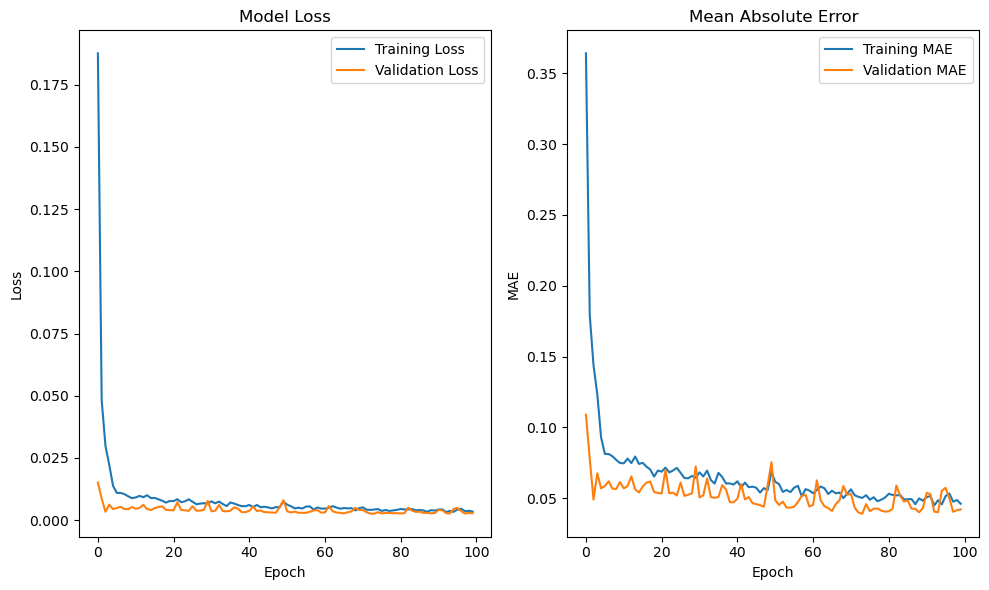

In [45]:
import matplotlib.pyplot as plt

print(future_prices)

def plot_training_history(history):
  """
  Plot training history for loss and MAE.

  Args:
  history (tf.keras.callbacks.History): Training history
  """

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['mae'], label='Training MAE')
  plt.plot(history.history['val_mae'], label='Validation MAE')
  plt.title('Mean Absolute Error')
  plt.xlabel('Epoch')
  plt.ylabel('MAE')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_training_history(history)

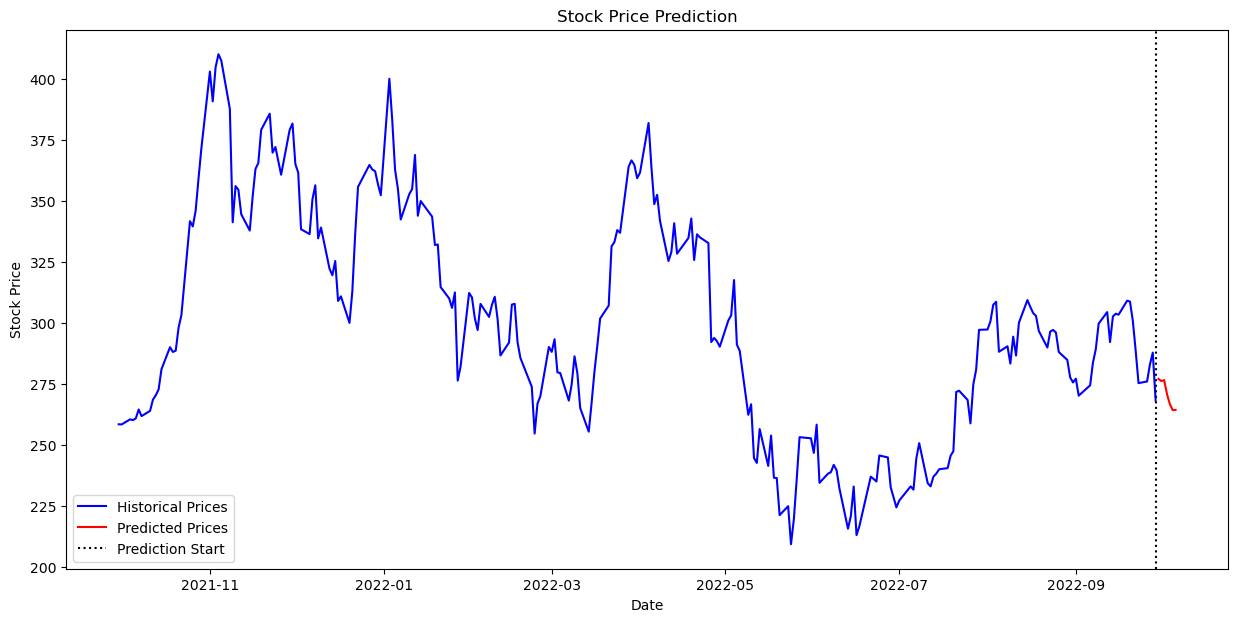

In [46]:
def plot_predictions(data, future_prices, future_days=5):
  last_date = pd.to_datetime(data['Date'].max())
  future_dates = pd.date_range(start=last_date, periods=future_days+1)[1:]

  plt.figure(figsize=(15, 7))
  plt.plot(data['Date'], data['Price'].values, label='Historical Prices', color='blue')
  plt.plot(future_dates, future_prices, label='Predicted Prices', color='red')

  plt.axvline(x=last_date, color='black', linestyle=':', label='Prediction Start')

  plt.title('Stock Price Prediction')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

plot_predictions(merged_data, future_prices, future_days=7)

In [47]:
def predict_stock_prices_full_range(model, data, lookback):
  """
  Predict stock prices for future days.

  Args:
  model (tf.keras.Model): Trained LSTM model
  data (pd.DataFrame): DataFrame with date, price, volume, and daily sentiment
  lookback (int): No. of previous days to use for prediction
  future_days (int): No. of future days to predict

  Returns:
  predictions (np.array): Predicted stock prices
  """

  sentiment_data = data['daily_sentiment'].values
  price_data = data['Price'].values
  dates = data['Date']

  sentiment_scaler = MinMaxScaler(feature_range=(-1, 1))
  price_scaler = MinMaxScaler(feature_range=(0, 1))

  sentiment_scaled = sentiment_scaler.fit_transform(sentiment_data.reshape(-1, 1))
  price_scaled = price_scaler.fit_transform(price_data.reshape(-1, 1))

  X, y_actual = [], []

  for i in range(len(data) - lookback):
    input_seq = np.column_stack([sentiment_scaled[i:i+lookback].flatten(), price_scaled[i:i+lookback].flatten()])
    X.append(input_seq)
    y_actual.append(price_scaled[i+lookback])

  X = np.array(X).reshape(len(X), lookback, 2)
  y_actual = np.array(y_actual)

  y_pred_scaled = model.predict(X)
  y_pred = price_scaler.inverse_transform(y_pred_scaled)
  y_actual = price_scaler.inverse_transform(y_actual)

  mse = np.mean((y_pred - y_actual)**2)
  mae = np.mean(np.abs(y_pred - y_actual))

  return {
      'dates': dates[lookback:],
      'actual_prices': y_actual.flatten(),
      'predicted_prices': y_pred.flatten(),
      'mse': mse,
      'mae': mae
  }

In [48]:
def plot_price_predictions(pred_results):
  plt.figure(figsize=(15, 7))

  plt.plot(pred_results['dates'], pred_results['actual_prices'], label='Actual Prices', color='blue')
  plt.plot(pred_results['dates'], pred_results['predicted_prices'], label='Predicted Prices', color='red')

  plt.title('Tesla Stock Prices: Actual vs. Predicted')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.legend()

  plt.text(0.05, 0.95,
           f'Mean Squared Error: ${pred_results["mse"]: .2f}\n'
           f'Mean Absolute Error: ${pred_results["mae"]: .2f}',
           transform=plt.gca().transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

  plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


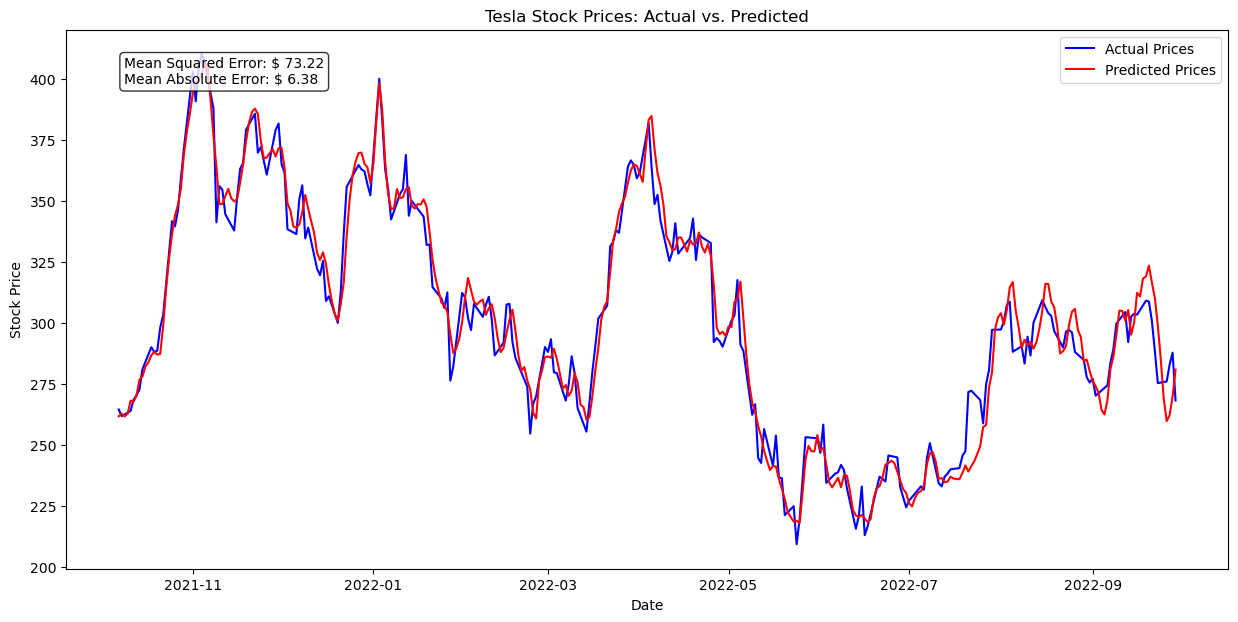

In [43]:
pred_results = predict_stock_prices_full_range(lstm_model, merged_data, lookback=7)
plot_price_predictions(pred_results)